# Descriptive Analysis

The heart of statistics and machine learning is the ability to describe data.  In order to do that, we sometimes need to first turn that data into categories or numerical values.  This lecture assumes you already have your data in one of those two forms.

From there the typical first step in analysis of data is to look at the central tendency and spread of your data, and make some data visualizations of the associated dataset.  

Let us begin by generating some synthetic data and applying some standard methods of analysis to it.  

# The Central Tendency

To begin with we will look at the central tendency.  If we are dealing with numerical data, that follows a normal distribution (more on what that means in a bit) then we can expect the following mathematical model to hold for the central tendency:

$$ 1/N \sum_{i=0}^{i=N} X[i] $$

Where X is the dataset, N is the number of elements in the dataset.  Let's look at an example, doing this in Python, with normally distributed data:

In [2]:
import numpy as np

arr = np.random.normal(0, 10, size=100000)
arr.mean()

0.055917152736664893

Notice that even with 100,000 samples we still don't recover the expected mean, which we know explicitly from the data generation process.  To get truly close to the expected mean of zero we will need many more samples.  We can visualize the convergence path that a normally distributed dataset takes as it gets increasingly close to zero for this distribution:

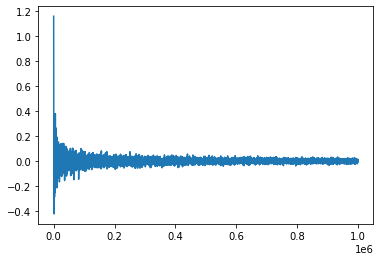

In [9]:
import matplotlib.pyplot as plt

means = []
indices = []
for i in range(100, 1000000, 100):
    arr = np.random.normal(0, 10, size=i)
    means.append(arr.mean())
    indices.append(i)
plt.plot(indices, means)

Similarly, if our data is normally distributed we can recover the spread of the data with the standard deviation or variance.  The data generating process we are using, makes use of the standard deviation, which is the square root of the variance.  We can equivalently see that the standard deviation does not equal the idealized value which we use for the data generation process: 

In [10]:
arr = np.random.normal(0, 10, size=100000)
arr.std()

10.001081654655678

However, the value does converge as the samples get large enough:

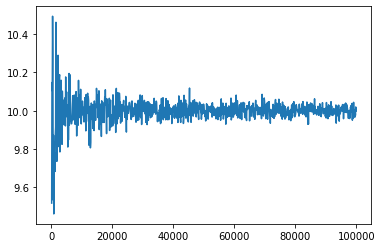

In [12]:
import matplotlib.pyplot as plt

standard_deviations = []
indices = []
for i in range(100, 100000, 100):
    arr = np.random.normal(0, 10, size=i)
    standard_deviations.append(arr.std())
    indices.append(i)
plt.plot(indices, standard_deviations)

Notice that, even if you know your population and sample distribution, for small sample sizes, your sample descriptive statistics may not equal your population descriptive statistics, even if the variance is low.  That's why when calculating a descriptive statistic, especially on a small population, it's best to bootstrap or simulate a confidence interval for your descriptive statistics.  

This does two things:

1. Helps you understand how much outliers are effecting your description of the data
2. Aids in approximating your population descriptive statistics.

Because simulation requires more mathematics we will opt for bootstrapping as a method of gaining confidence in our descriptive statistics, for now.  Later on in the course, we'll look at proper simulation with a method called maximum likelihood estimation.

The idea behind a bootstrap is sampling from your sample, with replacement.  The with replacement piece means that even if you've drawn a specific row from a sample before, you can still draw that sample again in the future.  

Let's put these ideas into practice to try and build a better sample:

In [49]:
import numpy as np
import pandas as pd

def rescale(data, new_max):
    old_max = data.max()
    new_data = (new_max/old_max) * (data - old_max) + new_max
    return new_data.astype(int)

def sampler(data, sample_size, seed=1, method="uniform", num_centers=4):
    np.random.seed(seed)
    index = list(range(len(data)))
    if method == "multimodal":
        start_percentile = (100//num_centers)/100
        percentiles = [
            np.percentile(data.shape[0], elem) 
            for elem in np.arange(
                start_percentile, 
                1, 
                start_percentile
            )
        ]
        
        new_index = np.array([])
        for percentile in percentiles:
            new_index = np.append(np.random.normal(
                loc=percentile,
                scale=data.shape[0]//(4*num_centers),
                size=sample_size//num_centers
            ), new_index)
    if method == "uniform":
        new_index = np.random.choice(
            index, size=sample_size
        )
    if method == "exponential":
        new_index = np.random.exponential(
            scale=data.shape[0]//2, 
            size=sample_size
        )
        new_index = rescale(
            new_index, data.shape[0]-1
        )
    if method == "gamma":
        shape = np.random.choice(
            [0.5, 3, 5]
        )
        new_index = np.random.gamma(
            shape=shape,
            scale=data.shape[0]//2, 
            size=sample_size
        )
        new_index = rescale(
            new_index, data.shape[0]-1
        )
    if method == "normal":
        new_index = np.random.normal(
            loc=data.shape[0]//2,
            scale=data.shape[0]//4,
            size=sample_size
        )
        new_index = rescale(
            new_index, data.shape[0]-1
        )
    if method == "poisson":
        new_index = np.random.poisson(
            lam=4,
            size=sample_size
        )
        new_index = rescale(
            new_index, data.shape[0]-1
        )
    if isinstance(data, np.ndarray):
        data = pd.Series(data)
    return data.iloc[new_index]

sample_size=150
for method in ["uniform", "poisson", "normal", "gamma", "exponential"]:
    data = pd.DataFrame(
        np.random.random(size=10000).reshape(100, 100)
    )
    sample = sampler(
        data, sample_size, seed=42, method=method
    )
    print(method, sample.shape)

choice (150, 100)
poisson (150, 100)
normal (150, 100)
gamma (150, 100)
exponential (150, 100)


As you can see, even though in this case we start with 100 samples, our sampler can generate more than 100 samples because we sample with replacement.  Additionally, we are able to randomly sample in either uniform or non-uniform way.  For instance, if we are interested in just getting samples from a certain part of the sample, like for instance from the middle, we'd use the normal distribution.  If we were interested in getting more samples 